# IMDB Text Sentiment Classification with RNN

- Word Seq -> Embedding ->  **GRU**  ->  Linear -> SoftMax
 

## References
1. https://www.kaggle.com/bhadreshsavani/aarya-sentimentalanalysis?scriptVersionId=17952789
1. https://m.blog.naver.com/PostView.nhn?blogId=gkvmsp&logNo=221485860027&proxyReferer=https:%2F%2Fwww.google.com%2F
    - 89%
1. https://github.com/bentrevett/pytorch-sentiment-analysis
    - Good
1. https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch
    - GRU, BiGRU, CNN

In [158]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets

In [159]:
%matplotlib inline

## Get IMDB sentiment classification data set
1. https://ai.stanford.edu/~amaas/data/sentiment/
1. Download, decompress

- The data was collected by Stanford researchers 
- and was used in a 2011 paper where a splitof 50-50 of the data was used for training and test. 
- An accuracy of 88.89% was achieved.

In [160]:
import os
os.listdir('../data/aclImdb/')

['imdb.vocab', 'imdbEr.txt', 'my_imdb.pkl', 'README', 'test', 'train']

In [161]:
# run $ python3 imdb_data_load.py to generate a pkl file from IMDB dataset

import imdb_data_load
#xtr, ytr, xte, yte = imdb_data_load.load_imdb('.data/imdb/aclImdb', loadpkl=False)
xtr, ytr, xte, yte = imdb_data_load.load_imdb('../data/aclImdb', loadpkl=True)

load_imdb():  ../data/aclImdb\my_imdb.pkl


### Let's have a look at the data

In [162]:
i = 0
print(f'label: {ytr[i]}\ndata[{i}]: (len: {len(xtr[i])}) {xtr[i][:10]}')
print('---')
print('xtr[0]>> ', xtr[0])
print('---')
print('xtr[500]>>', xtr[500])

label: 1
data[0]: (len: 140) ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the']
---
xtr[0]>>  ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........

## Vocabulary Making

- Vocab must be constructed with training data only.

In [163]:
vocab_src = set() # empty set
for word_list in xtr:
    vocab_src.update(word_list)
#
len(vocab_src)

280617

### Mapping from index to word, word to index

In [164]:
def get_maps(vocab):
    print('get_maps: ', len(vocab))
    word2indx, indx2word = {}, {}
    for v, w in enumerate(vocab):
        word2indx[w] = v
        indx2word[v] = w    # this can just be a list instead of {}
    return word2indx, indx2word
#

def get_words(i2w, inds):
    return [i2w[i] for i in inds]

word2indx_src, indx2word_src = get_maps(vocab_src)

get_maps:  280617


### Histogram of words in the whole dataset

- must include unknown word from test dataset

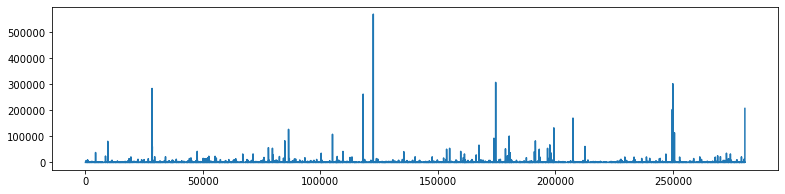

In [165]:
hist = np.zeros(len(vocab_src)+1, dtype=np.int)

for list_of_strings in [xtr, xte]:
    for wlst in list_of_strings:
        for w in wlst:
            if w in vocab_src:
                i = word2indx_src[w]
                hist[i] += 1
            else:
                hist[-1] += 1
                
#
plt.figure(figsize=(13,3))
plt.plot(hist)

In [166]:
print(f'* Maximum frequently used word: ', indx2word_src[np.argmax(hist)])
print(f'* Frequent Words:')
for i in range(len(vocab_src)):
    if hist[i] > 50000:
        print(indx2word_src[i], hist[i], end='; ')

* Maximum frequently used word:  the
* Frequent Words:
for 80919; of 283625; movie 60762; are 56513; film 54277; as 83130; that 126818; it 107916; to 261850; the 568735; you 50697; his 54198; but 66282; was 92658; a 306960; not 52140; /><br 100974; with 82569; be 50539; have 54009; The 67317; I 132498; in 169981; on 61197; is 203056; and 301919; this 113726; 

## Choose words and make a new vocab

In [167]:
mask = (7 <= hist ) & (hist < 50000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))
#
unk_indx = word2indx['<UNK>']
pad_indx = word2indx['<PAD>']

Chosen words: 58437  among  (280618,)
get_maps:  58441
size of new vocab:  58441


In [168]:
len(vocab), len(set(vocab))

(58441, 58441)

## Convert sentence (word-list) to list of integer index
- Embedding will be used for NN model

### Examine the lengths of all the sentences

mean: 233.7872, min: 10  max: 2470  std: 173.7, median: 174.0


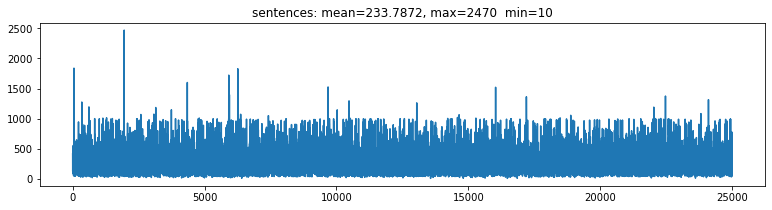

In [169]:
length = np.array([len(wlst) for wlst in xtr])
print(f'mean: {length.mean()}, min: {length.min()}  max: {length.max()}  std: {length.std():.1f}, median: {np.median(length)}')

plt.figure(figsize=(13,3))
plt.plot(length)
plt.title(f'sentences: mean={length.mean()}, max={max(length)}  min={min(length)}');

## Make Tensor array

In [170]:
max_len = 100  # we will use only 100 words per a sentence

In [171]:
def wseq2numpy(seq, vocab, word2indx, indx2word, max_len=200):
    """ seq: input, list of list of words, xtr or xte
        out: numpy array of ints [ [ 100, 23, 32], [32, 22, 10], ...]
    """
    print(len(seq), max_len)
    
    out = np.zeros((len(seq), max_len), dtype=np.int64)
    
    for i in range(len(seq)):
        s = seq[i]
        a = out[i]
        if len(s) >= max_len:   # if longer, trim
            s = s[:max_len]
        else:
            s = s + ['<PAD>' for i in range(max_len-len(s))]  # if shorter, pad
            
        for j, w in enumerate(s): # change to index 
            if w in vocab:
                a[j] = word2indx[w]
            else:
                a[j] = word2indx['<UNK>']
                
        if i == 0:
            print(f'{i} {seq[i]}')
    #
    return out

In [172]:
# set searching is much much faster than list searching
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

25000 100
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of'

In [173]:
xtrain.shape, xtrain[0]

((25000, 100),
 array([23953, 20812, 58439, 58439,  1736, 39714, 29372, 24384, 33347,
        58439, 17057, 50888, 58439,  1975, 49978, 37108, 51385, 30982,
        18420,  7749, 58439, 58439, 43393,  5779, 18467, 58439, 58439,
         8636, 28508, 49087, 41128, 58439, 22880, 58439, 23953, 58439,
        54206, 58439, 11702, 58367, 58439, 34497, 15897, 58439, 58439,
        58439,  8888, 58439, 13592, 58439, 58439, 47746, 43923, 37754,
        23716, 55839,  8773, 25405,  6145, 24890, 58439, 58439, 58439,
        58439, 58439, 58439, 17072, 44645, 56852, 55754, 41128, 58439,
        58439, 55675, 58439, 23271, 58439,  6145, 38084,  3814, 58439,
        33014, 58439, 50321, 58439, 47837, 58439, 46817, 32103, 16503,
        58439, 21180, 37910, 58439, 21079, 58439, 57469, 32108, 28108,
        33347], dtype=int64))

In [174]:
print(xtr[0])
print('---')
print(get_words(indx2word, xtrain[0]))

['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of', 'your', 't

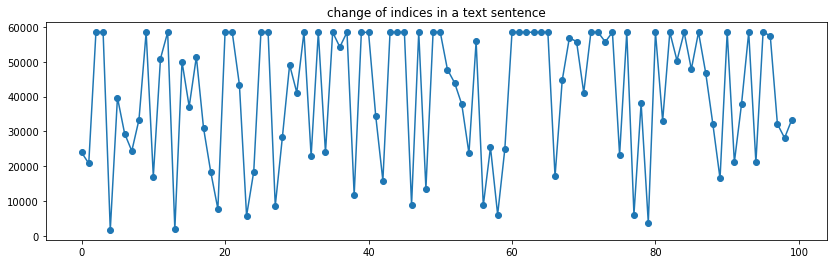

In [175]:
plt.figure(figsize=(14,4))
plt.plot(xtrain[0], '-o')
plt.title('change of indices in a text sentence');

In [176]:
word2indx['<UNK>']

58439

In [177]:
unique, counts = np.unique(xtrain[0], return_counts=True)
print(unique, counts)
print(indx2word[unique[np.argmax(counts)]])

[ 1736  1975  3814  5779  6145  7749  8636  8773  8888 11702 13592 15897
 16503 17057 17072 18420 18467 20812 21079 21180 22880 23271 23716 23953
 24384 24890 25405 28108 28508 29372 30982 32103 32108 33014 33347 34497
 37108 37754 37910 38084 39714 41128 43393 43923 44645 46817 47746 47837
 49087 49978 50321 50888 51385 54206 55675 55754 55839 56852 57469 58367
 58439] [ 1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  2  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 36]
<UNK>


---
## Dataset and Dataloader for PyTorch NN Modeling

In [178]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [179]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x  # np.array(N, max_len)
        self.y = y  # label
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [180]:
ds = Dataset(xtrain, ytr)
ds[21110]

(array([ 1753, 58439, 58439, 33544, 58439, 35234, 58439, 54718, 20833,
        56559, 58439, 40375, 19129, 58439, 58439, 58439, 26509, 58439,
         7140,    72, 58439, 58439, 26382, 51385, 58439, 58439, 58439,
        58439, 16295,  6708,  9982, 47720, 58439, 58439, 29398, 19668,
        54019, 49971, 51089, 52610, 18667, 58439,  7140, 23721, 58439,
        58439, 58439, 58439, 47428, 58439, 10945,  6145, 16295, 51089,
        13418, 58166, 22517, 58439, 28426, 11060, 58439, 51085, 18144,
        58439, 20446, 58439, 44523, 26382, 32258, 58439, 11060, 58439,
        23548,  2562, 19288, 47720, 58439, 58439, 29398, 19668, 44622,
        51089, 58439,  2187,  2086, 58439, 58439,  1860,  4136, 58439,
        46674, 18258, 28282,  7140, 58439, 58439, 28885,  2661, 46485,
        58439], dtype=int64), 0)

In [181]:
batch_size = 4
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

In [182]:
print(len(data_loader['train'].dataset), len(data_loader['val'].dataset))

for x, y in data_loader['train']:
    print(x.dtype, y.dtype)
    print(x.shape, y)
    break

25000 25000
torch.int64 torch.int64
torch.Size([4, 100]) tensor([1, 0, 0, 1])


## Network Design
Simple models with Conv1d():
1. nn.Embedding: word_index -> Euclidean Vector Mapping
1. nn.GRU()
1. nn.Linear()
1. AdaptiveAveragePooling()
1. Softmax + CrossEntropy = CrossEntropyLoss

### Practice layer by layer

#### nn.Embedding()

* Remember the output shape from embedding.
    - Batch x Sequence(Time) x Feature

In [183]:
vocab_size = len(vocab)
embed_dim = 9

emb = nn.Embedding(num_embeddings=vocab_size, 
                   embedding_dim=embed_dim,
                   padding_idx=word2indx['<PAD>'])

print('Embedding Weight: ', emb.weight.shape,'\n', emb.weight)
print('---')
for x, y in data_loader['train']:
    r = emb(x)
    print(f'input({x.shape}) --> embedded({r.shape})')
    break

Embedding Weight:  torch.Size([58441, 9]) 
 Parameter containing:
tensor([[ 0.4420,  0.2143, -0.9863,  ..., -0.4260, -0.9697,  0.4421],
        [-0.5756,  0.0901,  0.3842,  ...,  0.3718,  2.4344,  0.1391],
        [ 0.4683,  0.7853,  1.2510,  ..., -0.1644, -0.8290,  0.0683],
        ...,
        [ 1.3934,  0.6121, -0.5486,  ..., -0.0131,  1.1494, -0.1389],
        [-0.0961,  0.5658,  0.5923,  ..., -0.0726, -0.8366, -1.0680],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)
---
input(torch.Size([4, 100])) --> embedded(torch.Size([4, 100, 9]))


Notice that the output of embedding is of [B, T, F], where T is the time sequence length, F is the dimension of the feature vector at each time.

#### nn.GRU()

Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.

For each element in the input sequence, each layer computes the following function:
$$
\begin{array}{ll} r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\ z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\ n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\ h_t = (1 - z_t) * n_t + z_t * h_{(t-1)} \end{array} 
$$
where $x_t$ is input and $h_t$ is the output.

Since the input is a sequence, output is also a sequence.


**Parameters**:
```
    input_size – The number of expected features in the input x

    hidden_size – The number of features in the hidden state h

    num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, with the second GRU taking in outputs of the first GRU and computing the final results. Default: 1

    bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

    batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False

    dropout – If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer, with dropout probability equal to dropout. Default: 0

    bidirectional – If True, becomes a bidirectional GRU. Default: False
```
**Example**
```
>>> rnn = nn.GRU(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> output, hn = rnn(input, h0)
```

In [184]:
hidden_size = 11
num_layers = 2
gru = nn.GRU(input_size=9, hidden_size=11, num_layers=2, batch_first=True)

f, h = gru(r)  # <-- without initial hidden variable, default=0

print(f'input shape: {r.shape}')
print(f'GRU f.shape: {f.shape}, h.shape: {h.shape}') # <- h has 2 layer hidden output

input shape: torch.Size([4, 100, 9])
GRU f.shape: torch.Size([4, 100, 11]), h.shape: torch.Size([2, 4, 11])


Note that `f` is the sequence of hidden variables thru sequence. Hence, the last of `f` is equal to the last layer of `h`.

In [185]:
# f is the sequence of hidden variables thru sequence.
print('f: ', f[:,-1,:])
print('h: ', h[1,:,:])
print('diff: ', (f[:,-1,:] - h[1,:,:]).sum())

f:  tensor([[ 0.1070, -0.0580,  0.2527,  0.2247,  0.0334,  0.1055, -0.0776,  0.0559,
          0.0857,  0.0646, -0.1523],
        [ 0.0858, -0.0113,  0.3037,  0.1172, -0.1721,  0.1587,  0.1628, -0.0439,
          0.0144,  0.3723, -0.1803],
        [ 0.3457, -0.0763,  0.2354,  0.2562,  0.1492, -0.0994,  0.0477, -0.1535,
          0.2473,  0.2156, -0.1651],
        [ 0.1221, -0.0404,  0.2255,  0.2027, -0.1475,  0.1561, -0.0170,  0.0679,
          0.0399,  0.2138, -0.2272]], grad_fn=<SliceBackward>)
h:  tensor([[ 0.1070, -0.0580,  0.2527,  0.2247,  0.0334,  0.1055, -0.0776,  0.0559,
          0.0857,  0.0646, -0.1523],
        [ 0.0858, -0.0113,  0.3037,  0.1172, -0.1721,  0.1587,  0.1628, -0.0439,
          0.0144,  0.3723, -0.1803],
        [ 0.3457, -0.0763,  0.2354,  0.2562,  0.1492, -0.0994,  0.0477, -0.1535,
          0.2473,  0.2156, -0.1651],
        [ 0.1221, -0.0404,  0.2255,  0.2027, -0.1475,  0.1561, -0.0170,  0.0679,
          0.0399,  0.2138, -0.2272]], grad_fn=<SliceBackwar

In [186]:
h = torch.zeros(num_layers, batch_size, hidden_size) # <-- explicit initial hidden variable, output should be the same as above
f, h = gru(r, h)  

print(f'input shape: {r.shape}')
print(f'GRU f.shape: {f.shape}, h.shape: {h.shape}')

input shape: torch.Size([4, 100, 9])
GRU f.shape: torch.Size([4, 100, 11]), h.shape: torch.Size([2, 4, 11])


In [187]:
h = torch.randn(num_layers, batch_size, hidden_size) # <-- user defined initial hidden variable
f, h = gru(r, h)  

print(f'input shape: {r.shape}')
print(f'GRU f.shape: {f.shape}, h.shape: {h.shape}')

input shape: torch.Size([4, 100, 9])
GRU f.shape: torch.Size([4, 100, 11]), h.shape: torch.Size([2, 4, 11])


In [192]:
# bidirectional RNN
bigru = nn.GRU(input_size=9, hidden_size=11, num_layers=2, batch_first=True, bidirectional=True)  # <-- bidirectional

f2, h2 = bigru(r)
f2.shape, h2.shape , "Notice the feature dimension is now double the size of uni-directional"

(torch.Size([4, 100, 22]),
 torch.Size([4, 4, 11]),
 'Notice the feature dimension is now double the size of uni-directional')

In [62]:
f.mean(dim=1).shape

torch.Size([4, 11])

#### nn.Linear()

In [63]:
in_dim = hidden_size
out_dim = 2 # sentiment: [pos, neg]
linear = nn.Linear(in_features=in_dim, out_features=2)

fmean = f.mean(dim=1)

score = linear(fmean)
print(score.shape)

torch.Size([4, 2])


### Make NN Model

In [114]:
class GRUModel(nn.Module):
    def __init__(self, vocab_len, embedding_dim=40, seq_len=100, n_targets=2, dropout=0):
        super(GRUModel, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_len, 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=word2indx['<PAD>'])
        hidden_size = embedding_dim
        num_layers = 2
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=dropout)

        self.flatten = nn.Flatten()
        
        in_features = hidden_size * seq_len
        self.score = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(in_features=in_features, out_features=in_features//2),
                                    nn.BatchNorm1d(in_features//2),
                                    nn.ReLU(),
                                    nn.Linear(in_features=in_features//2, out_features=n_targets)
                                    )        
    def forward(self, x):        
        x = self.embedding(x)
        x, h = self.gru(x)
        x = self.score(x) # <-- mean along time axis
        
        return x
#
class GRU_Dropout_Model(nn.Module):
    def __init__(self, vocab_len, embedding_dim=40, seq_len=100, n_targets=2):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_len, 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=word2indx['<PAD>'])
        hidden_size = embedding_dim
        num_layers = 2
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=2, batch_first=True)

        self.flatten = nn.Flatten()
        
        in_features = hidden_size * seq_len
        self.score = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(in_features=in_features, out_features=in_features//2),
                                    nn.BatchNorm1d(in_features//2),
                                    nn.ReLU(),
                                    nn.Linear(in_features=in_features//2, out_features=n_targets),
                                    nn.Dropout()
                                    )        
    def forward(self, x):        
        x = self.embedding(x)
        x, h = self.gru(x)
        x = self.score(x) # <-- mean along time axis
        
        return x
#

def make_model(vocab_size, embedding_dim, option=1):
    if option == 1:
        return GRUModel(vocab_size, embedding_dim=embedding_dim)
    elif option == 2:
        return GRU_Dropout_Model(vocab_size, embedding_dim=embedding_dim)
    elif option == 3:
        return GRUModel(vocab_size, embedding_dim=embedding_dim, dropout=0.5) # dropout probability 0.5
    else:
        return None
#

In [112]:
net = make_model(vocab_size, embedding_dim=50)

print(net)
net(x).shape

GRUModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (gru): GRU(50, 50, num_layers=2, batch_first=True)
  (flatten): Flatten()
  (score): Sequential(
    (0): Flatten()
    (1): Linear(in_features=5000, out_features=2500, bias=True)
    (2): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=2, bias=True)
  )
)


torch.Size([4, 2])

## Training Setup

In [102]:
import training_loop as tx
#
vocab_len = len(vocab)

In [105]:
batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu') # for debuging
print(device)


model = make_model(option=1, vocab_size=vocab_len, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

history = None

cuda
GRUModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (gru): GRU(50, 50, num_layers=2, batch_first=True)
  (flatten): Flatten()
  (score): Sequential(
    (0): Flatten()
    (1): Linear(in_features=5000, out_features=2500, bias=True)
    (2): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=2, bias=True)
  )
)
total number of parameters:  15465152 embeddin:  2922050


## First Try

Epoch 1, tloss 1.80 t_acc: 0.50  vloss 4.00  v_acc: 0.50
Epoch 2, tloss 0.89 t_acc: 0.51  vloss 0.77  v_acc: 0.50
Epoch 3, tloss 0.95 t_acc: 0.56  vloss 0.79  v_acc: 0.50
Epoch 4, tloss 0.57 t_acc: 0.70  vloss 0.55  v_acc: 0.73
Epoch 5, tloss 0.36 t_acc: 0.84  vloss 0.80  v_acc: 0.69
Epoch 100, tloss 0.00 t_acc: 1.00  vloss 2.33  v_acc: 0.76
finished training_loop().
Wall time: 2min 22s


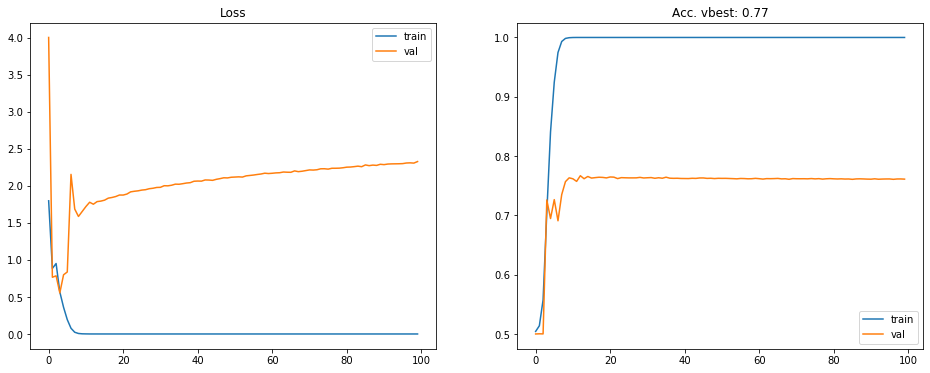

In [106]:
%%time
history = tx.training_loop(100, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            history, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

The accuracy and loss graphs show that the network is fully experiencing the overfit phenomenon. We need some way to prevent this.

## Model with Dropout

cuda
GRU_Dropout_Model(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (gru): GRU(50, 50, num_layers=2, batch_first=True)
  (flatten): Flatten()
  (score): Sequential(
    (0): Flatten()
    (1): Linear(in_features=5000, out_features=2500, bias=True)
    (2): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=2, bias=True)
    (5): Dropout(p=0.5, inplace=False)
  )
)
total number of parameters:  15465152 embeddin:  2922050
Epoch 1, tloss 2.14 t_acc: 0.50  vloss 5.05  v_acc: 0.50
Epoch 2, tloss 0.77 t_acc: 0.53  vloss 2.50  v_acc: 0.50
Epoch 3, tloss 0.69 t_acc: 0.63  vloss 0.99  v_acc: 0.53
Epoch 4, tloss 0.56 t_acc: 0.70  vloss 1.59  v_acc: 0.50
Epoch 5, tloss 0.46 t_acc: 0.76  vloss 0.55  v_acc: 0.75
Epoch 100, tloss 0.17 t_acc: 0.88  vloss 2.41  v_acc: 0.76
finished training_loop().
Wall time: 2min 21s


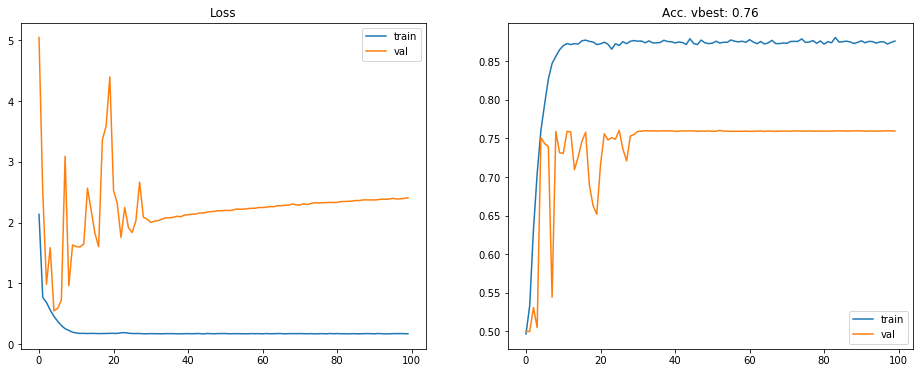

In [115]:
%%time

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=2, vocab_size=vocab_len, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(100, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

## With Two Dropouts

cuda
GRUModel(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (gru): GRU(50, 50, num_layers=2, batch_first=True, dropout=0.5)
  (flatten): Flatten()
  (score): Sequential(
    (0): Flatten()
    (1): Linear(in_features=5000, out_features=2500, bias=True)
    (2): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=2500, out_features=2, bias=True)
  )
)
total number of parameters:  15465152 embeddin:  2922050
Epoch 1, tloss 1.95 t_acc: 0.50  vloss 21.87  v_acc: 0.50
Epoch 2, tloss 0.70 t_acc: 0.56  vloss 0.78  v_acc: 0.56
Epoch 3, tloss 0.56 t_acc: 0.71  vloss 0.61  v_acc: 0.70
Epoch 4, tloss 0.39 t_acc: 0.83  vloss 0.57  v_acc: 0.76
Epoch 5, tloss 0.22 t_acc: 0.91  vloss 0.64  v_acc: 0.77
Epoch 100, tloss 0.00 t_acc: 1.00  vloss 3.06  v_acc: 0.76
finished training_loop().
Wall time: 2min 34s


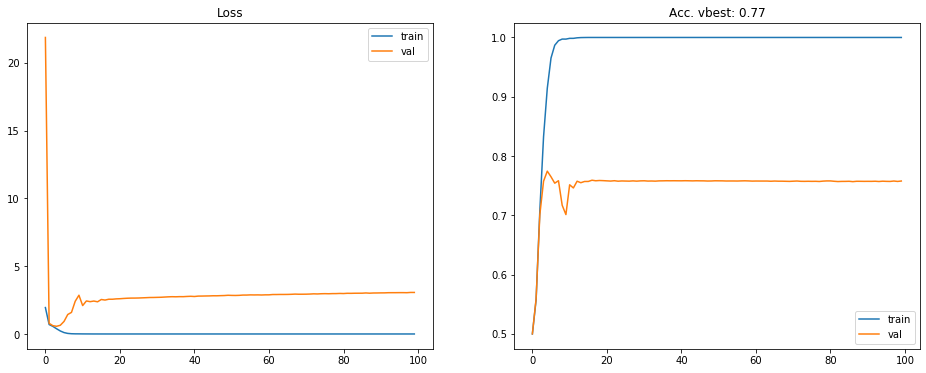

In [116]:
%%time

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = make_model(option=3, vocab_size=vocab_len, embedding_dim=50).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(100, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

---

## Use the final hidden states
---

In [197]:
class MeanHidden(nn.Module):
    def __init__(self,):
        super().__init__()
        pass
    def forward(self, x, dim=1):
        return x.mean(dim=dim)

class LastHidden(nn.Module):
    def __init__(self,):
        super().__init__()
        pass
    def forward(self, x):
        return x[:, -1, :] # the last time
    
class GRU_Model(nn.Module):
    def __init__(self, vocab_len, embedding_dim=40, n_targets=2, dropout=0, num_layers=2, feat='mean', pad_indx=None, bigru=False):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_len, 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=pad_indx if pad_indx is not None else word2indx['<PAD>'] )
        hidden_size = embedding_dim
        
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bigru)

        if feat == 'mean':
            self.feat = MeanHidden()
        elif feat == 'last':
            self.feat = LastHidden()
            
        in_features = hidden_size
        self.score = nn.Sequential(
                                    nn.Flatten(), # actually not necessary
                                    nn.Linear(in_features=in_features, out_features=in_features//2),
                                    nn.BatchNorm1d(in_features//2),
                                    nn.ReLU(),
                                    nn.Linear(in_features=in_features//2, out_features=n_targets)
                                    )        
    def forward(self, x):        
        x = self.embedding(x)
        x, h = self.gru(x) # x: BTF,  h: LBF
        x = self.feat(x)
        x = self.score(x) # <-- mean along time axis
        
        return x
#


cuda
GRU_Model(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (gru): GRU(50, 50, num_layers=2, batch_first=True, dropout=0.5)
  (feat): MeanHidden()
  (score): Sequential(
    (0): Flatten()
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=2, bias=True)
  )
)
total number of parameters:  2954027 embeddin:  2922050
Epoch 1, tloss 0.64 t_acc: 0.63  vloss 0.58  v_acc: 0.69
Epoch 2, tloss 0.42 t_acc: 0.81  vloss 0.57  v_acc: 0.74
Epoch 3, tloss 0.25 t_acc: 0.90  vloss 0.50  v_acc: 0.78
Epoch 4, tloss 0.12 t_acc: 0.96  vloss 1.28  v_acc: 0.69
Epoch 5, tloss 0.04 t_acc: 0.99  vloss 1.12  v_acc: 0.77
Epoch 10, tloss 0.00 t_acc: 1.00  vloss 1.49  v_acc: 0.77
finished training_loop().
Wall time: 11.2 s


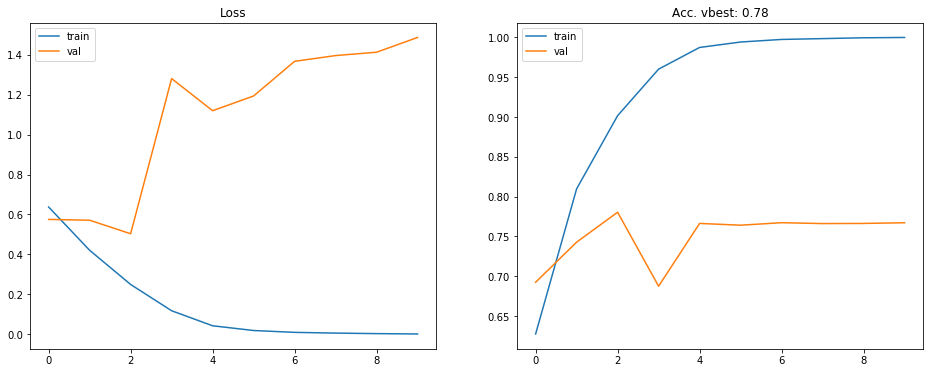

In [142]:
%%time

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GRU_Model(vocab_len=vocab_len, embedding_dim=50, seq_len=100, n_targets=2, dropout=0.5, num_layers=2, feat='mean').to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

cuda
GRU_Model(
  (embedding): Embedding(58441, 50, padding_idx=58440)
  (gru): GRU(50, 50, num_layers=2, batch_first=True, dropout=0.5)
  (feat): LastHidden()
  (score): Sequential(
    (0): Flatten()
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=2, bias=True)
  )
)
total number of parameters:  2954027 embeddin:  2922050
Epoch 1, tloss 0.70 t_acc: 0.51  vloss 0.70  v_acc: 0.51
Epoch 2, tloss 0.65 t_acc: 0.62  vloss 1.33  v_acc: 0.56
Epoch 3, tloss 0.42 t_acc: 0.81  vloss 0.47  v_acc: 0.78
Epoch 4, tloss 0.22 t_acc: 0.92  vloss 0.53  v_acc: 0.77
Epoch 5, tloss 0.09 t_acc: 0.97  vloss 1.05  v_acc: 0.74
Epoch 10, tloss 0.00 t_acc: 1.00  vloss 1.42  v_acc: 0.77
finished training_loop().
Wall time: 11.5 s


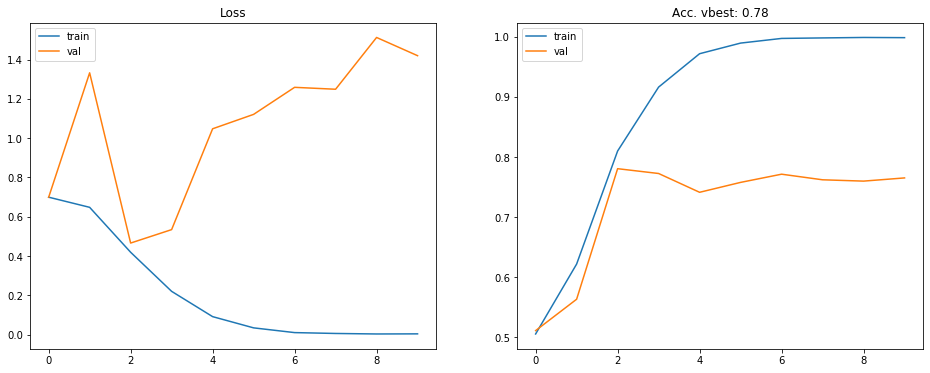

In [145]:
%%time

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GRU_Model(vocab_len=vocab_len, embedding_dim=50, seq_len=100, n_targets=2, dropout=0.5, num_layers=2, feat='last').to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

25000 200
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'High.', 'A', 'classic', 'line:', 'INSPECTOR:', "I'm", 'here', 'to', 'sack', 'one', 'of'

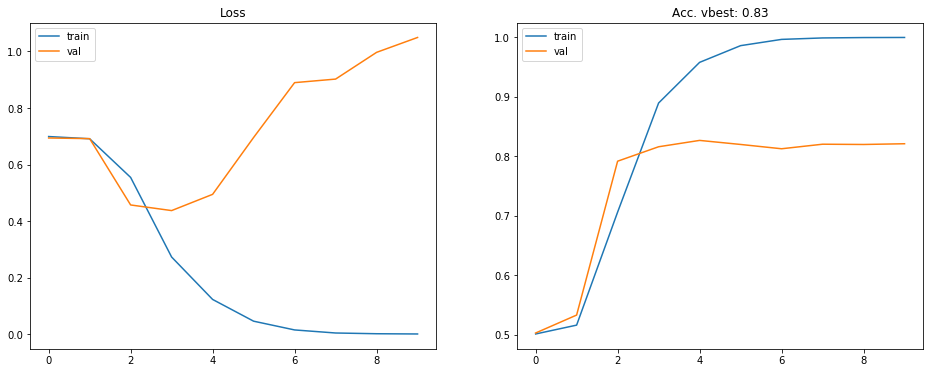

In [147]:
%%time

# set searching is much much faster than list searching
max_len = 200
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

# ---

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GRU_Model(vocab_len=vocab_len, embedding_dim=50, seq_len=100, n_targets=2, dropout=0.5, num_layers=2, feat='last').to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

Chosen words: 58437  among  (280618,)
get_maps:  58441
size of new vocab:  58441


Chosen words: 107317  among  (280618,)
get_maps:  107321
size of new vocab:  107321
25000 200
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'Hig

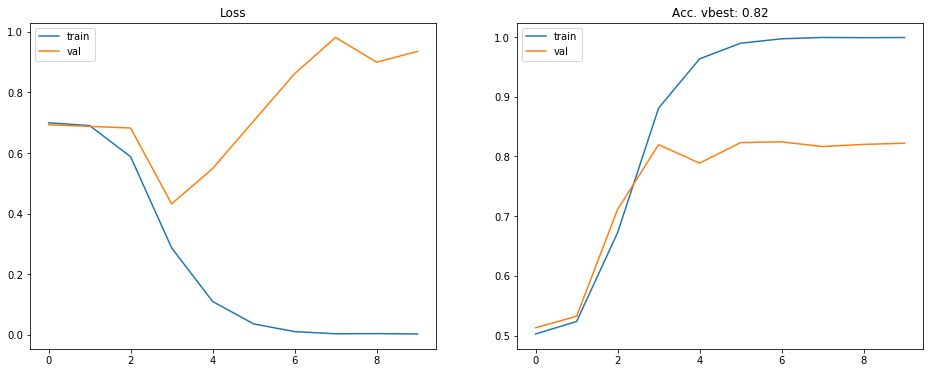

In [152]:
%%time

mask = (3 <= hist ) & (hist < 150000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))

# set searching is much much faster than list searching
max_len = 200
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

# ---

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GRU_Model(vocab_len=len(vocab), embedding_dim=50, seq_len=100, n_targets=2, dropout=0.5, num_layers=2, feat='last', pad_indx=word2indx['<PAD>']).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

Chosen words: 107317  among  (280618,)
get_maps:  107321
size of new vocab:  107321
25000 200
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'Hig

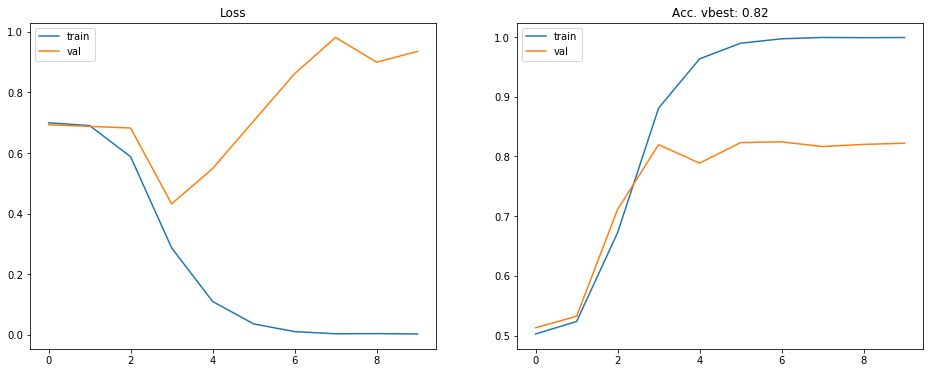

In [152]:
%%time

mask = (3 <= hist ) & (hist < 150000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))

# set searching is much much faster than list searching
max_len = 200
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

# ---

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GRU_Model(vocab_len=len(vocab), embedding_dim=50, n_targets=2, dropout=0.5, 
                  num_layers=2, 
                  feat='last', 
                  pad_indx=word2indx['<PAD>']).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

Chosen words: 107317  among  (280618,)
get_maps:  107321
size of new vocab:  107321
25000 200
0 ['Bromwell', 'High', 'is', 'a', 'cartoon', 'comedy.', 'It', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life,', 'such', 'as', '"Teachers".', 'My', '35', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'Bromwell', "High's", 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', '"Teachers".', 'The', 'scramble', 'to', 'survive', 'financially,', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', "teachers'", 'pomp,', 'the', 'pettiness', 'of', 'the', 'whole', 'situation,', 'all', 'remind', 'me', 'of', 'the', 'schools', 'I', 'knew', 'and', 'their', 'students.', 'When', 'I', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school,', 'I', 'immediately', 'recalled', '.........', 'at', '..........', 'Hig

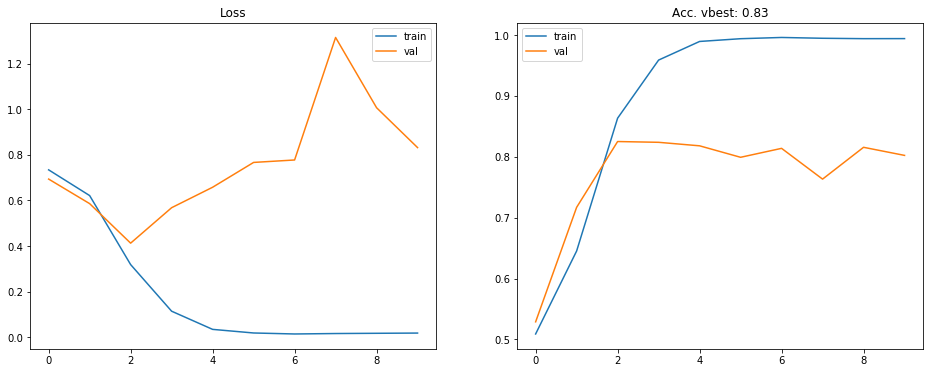

In [193]:
%%time

mask = (3 <= hist ) & (hist < 150000)
print(f'Chosen words: {mask.sum()}  among  {mask.shape}')
windx = [i for i in range(len(mask)) if mask[i]]

# new vocab and maps
vocab = [indx2word_src[i] for i in windx] + ['<SOS>', '<EOS>', '<UNK>', '<PAD>']
word2indx, indx2word = get_maps(vocab)

print('size of new vocab: ', len(vocab))

# set searching is much much faster than list searching
max_len = 200
xtrain = wseq2numpy(xtr, set(vocab), word2indx, indx2word, max_len=max_len)
xtest  = wseq2numpy(xte, set(vocab), word2indx, indx2word, max_len=max_len)

# ---

batch_size = 1024
data_loader = {'train': torch.utils.data.DataLoader(Dataset(xtrain, ytr),  batch_size=batch_size, shuffle=True),
                 'val': torch.utils.data.DataLoader(Dataset(xtest, yte),   batch_size=batch_size)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = GRU_Model(vocab_len=len(vocab), 
                  embedding_dim=250, n_targets=2, dropout=0.5, 
                  num_layers=2, 
                  feat='last', 
                  pad_indx=word2indx['<PAD>']).to(device)
print(model)
print('total number of parameters: ', tx.count_params(model), 'embeddin: ', tx.count_params(model.embedding))

criterion = torch.nn.CrossEntropyLoss().to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

#
history = tx.training_loop(10, optimizer, model, criterion,
                            data_loader['train'], data_loader['val'], 
                            hist=None, 
                            lr_scheduler=lr_scheduler,
                            device=device)
tx.plot_history(history)

---
## Embedding Space Analysis
---

torch.Size([58441, 2])
x:  (25000, 100) <class 'numpy.ndarray'>
unique(x[y==0]):  (44707,)
unique(x[y==1]):  (44949,)
x:  torch.Size([25000, 1, 100])
e:  torch.Size([25000, 1, 100, 2])
25000 <class 'numpy.ndarray'> (12500,) [0 0 0 ... 0 0 0]
en, ep:  torch.Size([12500, 1, 100, 2]) torch.Size([12500, 1, 100, 2])
torch.Size([12500, 1, 100, 2])
en, ep:  torch.Size([1250000, 2]) torch.Size([1250000, 2])


Text(0.5, 1.0, 'Embedding weight vectors. G: all, B: pos, R: neg')

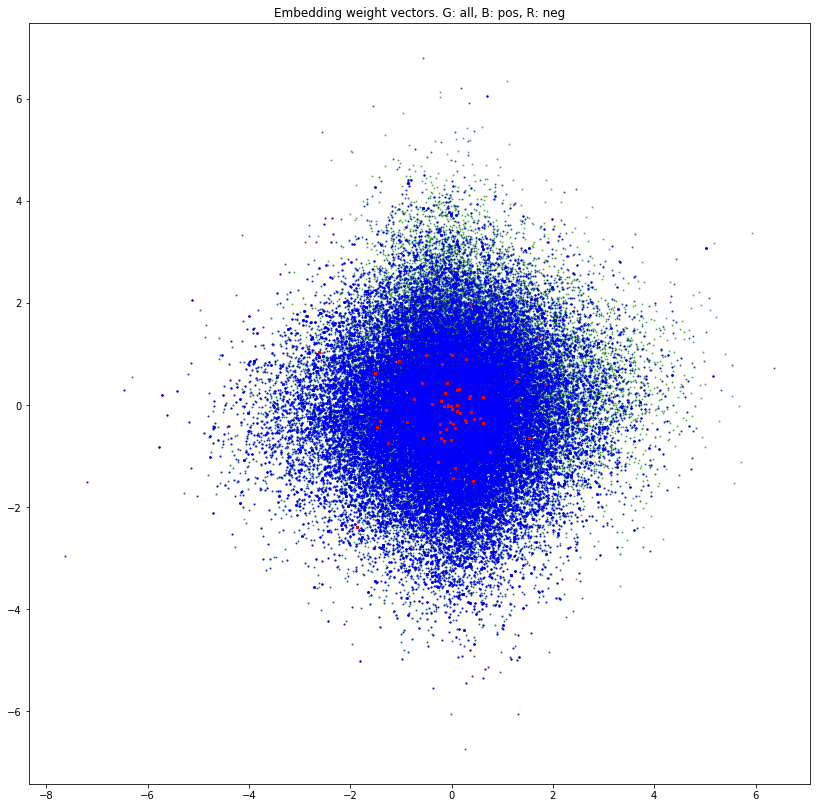

In [69]:
plt.figure(figsize=(14,14))
w = model.embedding.weight.data.cpu()
print(w.shape)
plt.scatter(w[:,0], w[:,1], alpha=0.5, s=1, c='g') # un-used weights exist due to sentence trimming.

with torch.no_grad():
    x, y = data_loader['train'].dataset[:] # the first in the dataset
    y = np.array(y)
    
    print('x: ', x.shape, type(x))
    uniq = np.unique(x[y==0])
    print('unique(x[y==0]): ', uniq.shape)
    print('unique(x[y==1]): ', np.unique(x[y==1]).shape)
    
    x = torch.from_numpy(x).to(device).unsqueeze(1) #
    print('x: ', x.shape)
    e = model.embedding(x).cpu()
print('e: ', e.shape)

yn = y[y==0]
print(len(y), type(y), yn.shape, yn)

e_neg = e[yn]
e_pos = e[y==1]
print('en, ep: ', e_neg.shape, e_pos.shape)
print(e_neg.shape)

e_neg = e_neg.reshape(-1,2)
e_pos = e_pos.reshape(-1,2)
print('en, ep: ', e_neg.shape, e_pos.shape)

plt.scatter(e_pos[:,0], e_pos[:,1], c='b', alpha=0.3, s=1)
plt.scatter(e_neg[:,0], e_neg[:,1], c='r', alpha=0.3, s=2)

plt.title('Embedding weight vectors. G: all, B: pos, R: neg')
# 

torch.Size([1250000, 2])


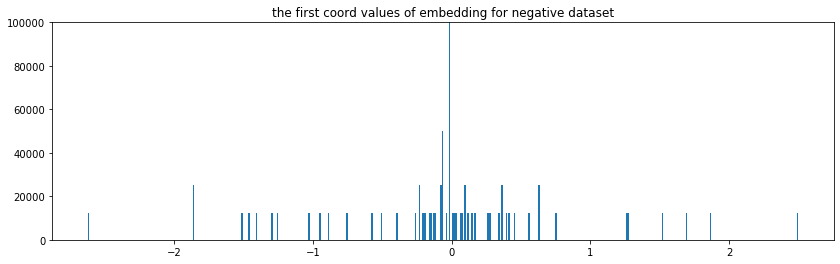

In [70]:
print(e_neg.shape)
plt.figure(figsize=(14,4))
plt.hist(e_neg[:,0].reshape(-1), bins=500)
plt.ylim((0,100000))
plt.title('the first coord values of embedding for negative dataset');

torch.Size([25000, 1, 100, 2])

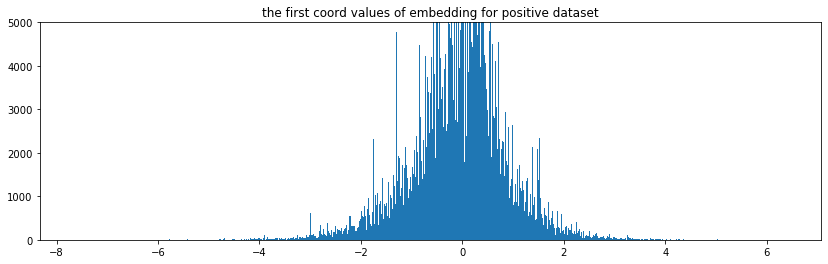

In [71]:
plt.figure(figsize=(14,4))
plt.hist(e_pos[:,0].reshape(-1), bins=1000)
plt.ylim((0,5000))
plt.title('the first coord values of embedding for positive dataset')
e.shape

## Hypter parameters
- the number of words (size of vocab)
- maximum length of the sequence
    - choose this number will change the number of vocabs of the training data. So, practically this selection should precede the choice of word dictionary (which was done based on the histogram of occurance)
- embedding dimension
- architecture of the feature network
    - 1D resnet, e.g.
- learning rate, schedule

## References
- [https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data](https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data)
- https://github.com/lesley2958/twilio-sent-analysis
- https://github.com/radoslawkrolikowski/sentiment-analysis-pytorch